In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-vs-human-text/AI_Human.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import  get_linear_schedule_with_warmup
from torch.optim import AdamW

from tqdm.auto import tqdm
import gc
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")

Using device: cuda
Using 2 GPUs!


In [4]:
# Load data
df = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())


Dataset shape: (487235, 2)

First few rows:
                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0


In [5]:

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check class distribution
print("\nClass distribution:")
print(df['generated'].value_counts())

# Sample distribution visualization
plt.figure(figsize=(8, 5))
sns.countplot(x='generated', data=df)
plt.title('Distribution of Human vs AI Generated Text')
plt.xlabel('AI Generated (1) vs Human Text (0)')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.close()


Missing values:
text         0
generated    0
dtype: int64

Class distribution:
generated
0.0    305797
1.0    181438
Name: count, dtype: int64


In [6]:
# Prepare data for training
# Convert text to list and labels to numpy array
texts = df['text'].tolist()
labels = df['generated'].values

# Split data into training, validation and test sets (70%, 15%, 15%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=seed, stratify=labels
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=seed, stratify=temp_labels
)

print(f"\nTrain set: {len(train_texts)} samples")
print(f"Validation set: {len(val_texts)} samples")
print(f"Test set: {len(test_texts)} samples")


Train set: 341064 samples
Validation set: 73085 samples
Test set: 73086 samples


In [7]:
# Define model name
model_name = "roberta-base"  # You can try "distilbert-base-uncased" for faster training

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 256  # You can adjust this based on your texts

print(f"\nUsing {model_name} with max sequence length of {max_length}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Using roberta-base with max sequence length of 256


In [9]:
# Create a PyTorch Dataset
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [10]:
# Create DataLoaders
def create_dataloaders(train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, 
                     tokenizer, max_length, batch_size):
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
    val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
    test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)
    
    return train_dataloader, val_dataloader, test_dataloader

In [11]:

# Training function for one epoch
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions = []
    actual_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        actual_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(actual_labels, predictions)
    
    return avg_loss, accuracy, predictions, actual_labels

In [12]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            # Get predictions
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            actual_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(actual_labels, predictions)
    
    return avg_loss, accuracy, predictions, actual_labels

In [13]:
# Create dataloaders
batch_size =64  # Adjust based on GPU memory
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(
    train_texts, val_texts, test_texts, 
    train_labels, val_labels, test_labels,
    tokenizer, max_length, batch_size
)

# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    problem_type="single_label_classification"
)

2025-05-02 10:03:06.015383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746180186.175151      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746180186.217256      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:

# Move model to GPU and use DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
model = model.to(device)

In [16]:
# Set up optimizer and learning rate scheduler
epochs = 2  # You can increase this for better accuracy
learning_rate = 2e-5
warmup_steps = int(0.1 * len(train_dataloader) * epochs)  # 10% of total steps
total_steps = len(train_dataloader) * epochs


In [17]:
# Use AdamW optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [18]:
# Training loop
best_val_accuracy = 0
training_stats = []

for epoch in range(epochs):
    print(f"\n{'='*20} Epoch {epoch+1}/{epochs} {'='*20}")
    
    # Manual training loop instead of using train_epoch function
    model.train()
    total_train_loss = 0
    train_preds = []
    train_true_labels = []
    
    for batch in tqdm(train_dataloader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        # Fix for multi-GPU setup: if loss is a tensor with multiple elements, use mean
        loss = outputs.loss
        if loss.dim() > 0:
            loss = loss.mean()
        
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Get predictions
        logits = outputs.logits
        if logits.dim() > 2:  # Handle multi-GPU case
            logits = logits.view(-1, logits.size(-1))
        
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        train_preds.extend(preds)
        train_true_labels.extend(labels.cpu().numpy())
    
    train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = accuracy_score(train_true_labels, train_preds)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    
    # Manual validation loop instead of using evaluate function
    print("\nValidating...")
    model.eval()
    total_val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            # Fix for multi-GPU setup: if loss is a tensor with multiple elements, use mean
            loss = outputs.loss
            if loss.dim() > 0:
                loss = loss.mean()
                
            total_val_loss += loss.item()
            
            # Get predictions
            logits = outputs.logits
            if logits.dim() > 2:  # Handle multi-GPU case
                logits = logits.view(-1, logits.size(-1))
                
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
    
    val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Save stats
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })
    
    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        
        # Save model
        output_dir = './best_model'
        os.makedirs(output_dir, exist_ok=True)
        
        if isinstance(model, torch.nn.DataParallel):
            model_to_save = model.module
        else:
            model_to_save = model
            
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
        
        print(f"Saved new best model with validation accuracy: {val_accuracy:.4f}")
    
    # Print classification report for validation set
    print("\nValidation Classification Report:")
    print(classification_report(val_labels, val_preds))
    
    # Clear memory
    gc.collect()
    torch.cuda.empty_cache()

# Convert training stats to DataFrame for easy visualization
stats_df = pd.DataFrame(training_stats)
print("\nTraining Statistics:")
print(stats_df)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(stats_df['train_loss'], label='Train')
plt.plot(stats_df['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(stats_df['train_accuracy'], label='Train')
plt.plot(stats_df['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.close()


==================== Epoch 1/2 ====================


Training:   0%|          | 0/5330 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Train Loss: 0.0313, Train Accuracy: 0.9862

Validating...


Validating:   0%|          | 0/1142 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Validation Loss: 0.0118, Validation Accuracy: 0.9973
Saved new best model with validation accuracy: 0.9973

Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45869
           1       0.99      1.00      1.00     27216

    accuracy                           1.00     73085
   macro avg       1.00      1.00      1.00     73085
weighted avg       1.00      1.00      1.00     73085


==================== Epoch 2/2 ====================


Training:   0%|          | 0/5330 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Train Loss: 0.0008, Train Accuracy: 0.9998

Validating...


Validating:   0%|          | 0/1142 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Validation Loss: 0.0071, Validation Accuracy: 0.9989
Saved new best model with validation accuracy: 0.9989

Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45869
           1       1.00      1.00      1.00     27216

    accuracy                           1.00     73085
   macro avg       1.00      1.00      1.00     73085
weighted avg       1.00      1.00      1.00     73085


Training Statistics:
   epoch  train_loss  train_accuracy  val_loss  val_accuracy
0      1    0.031335        0.986217  0.011787      0.997318
1      2    0.000758        0.999833  0.007129      0.998878


In [19]:
# Load the best model for evaluation
best_model = AutoModelForSequenceClassification.from_pretrained('./best_model')
best_model = best_model.to(device)


In [20]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy, test_preds, test_labels = evaluate(best_model, test_dataloader, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Evaluating on test set...


Evaluating:   0%|          | 0/1142 [00:00<?, ?it/s]

Test Loss: 0.0087, Test Accuracy: 0.9985


In [21]:
# Print classification report for test set
print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds))


Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45870
           1       1.00      1.00      1.00     27216

    accuracy                           1.00     73086
   macro avg       1.00      1.00      1.00     73086
weighted avg       1.00      1.00      1.00     73086



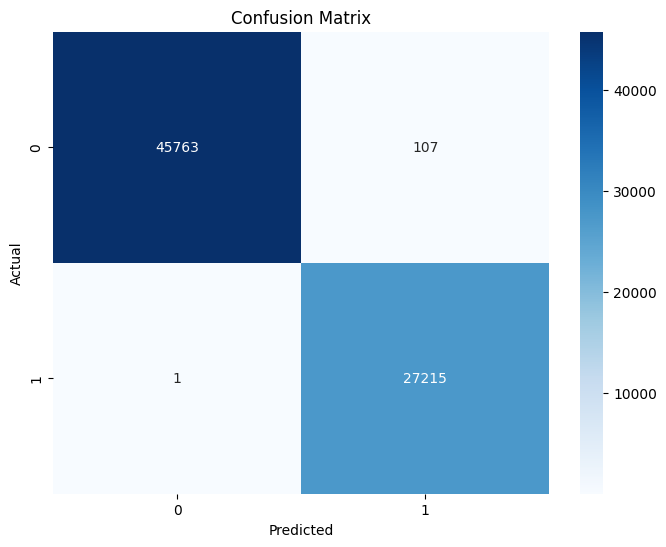

In [23]:
# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()


In [ ]:
# Save the model to output directory
output_dir = "/kaggle/working/ai_vs_human_model"
os.makedirs(output_dir, exist_ok=True)

In [32]:
# Save the final model
if isinstance(best_model, torch.nn.DataParallel):
    model_to_save = best_model.module
else:
    model_to_save = best_model

model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"\nFinal model saved to {output_dir}")



Final model saved to /kaggle/working/ai_vs_human_model


In [48]:
# Save a test prediction function
with open(f"{output_dir}/predict.py", "w") as f:
    f.write("""
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def predict(text, model_path="./"):
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Tokenize input
    inputs = tokenizer(
        text,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Move inputs to device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Get probabilities and predicted class
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    # Return prediction and probability
    return {
        "prediction": "AI Generated" if predicted_class == 1 else "Human Written",
        "class": predicted_class,
        "probability": probabilities[0][predicted_class].item()
    }

# Example usage
if __name__ == "__main__":
    test_text = "This is a sample text to classify."
    result = predict(test_text)
    print(f"Prediction: {result['prediction']}")
    print(f"Class: {result['class']}")
    print(f"Probability: {result['probability']:.4f}")
""")

print("\nAlso saved a prediction script at {}/predict.py".format(output_dir))

# Try the model on a few examples
print("\nTesting the model on a few examples:")
example_texts = [
    "The Electoral College has been kept for centuries as a way to balance power.",
    "Artificial intelligence systems have been designed to generate text that mimics human writing patterns.",
    
]

best_model.eval()
for text in example_texts:
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
    
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    print("\nText:", text)
    print("Prediction:", "AI Generated" if predicted_class == 1 else "Human Written")
    print(f"Probability: {probabilities[0][predicted_class].item():.4f}")

# Print final summary
print("\n" + "="*50)
print("Training Complete!")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("="*50)


Also saved a prediction script at /kaggle/working/ai_vs_human_model/predict.py

Testing the model on a few examples:

Text: The Electoral College has been kept for centuries as a way to balance power.
Prediction: AI Generated
Probability: 1.0000

Text: Artificial intelligence systems have been designed to generate text that mimics human writing patterns.
Prediction: AI Generated
Probability: 1.0000

Training Complete!
Best Validation Accuracy: 0.9989
Test Accuracy: 0.9985
